# Advanced Signal Combinations Framework

## Multi-Signal Trading Strategies

This notebook implements combinations of advanced signals from our signal bank, creating robust multi-factor trading strategies.

### Combination Strategy Categories:

- **Regime-Aware Combinations** - Adapt strategy based on market conditions
- **Confirmation-Based Strategies** - Multiple signals must agree
- **Ensemble Methods** - Weighted voting systems
- **Hierarchical Filtering** - Primary signals with secondary filters

---

In [1]:
# Setup and imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# QuantConnect imports
from AlgorithmImports import *

# Set up QuantBook
qb = QuantBook()
np.random.seed(42)

print("Signal Combinations Framework Initialized")
print("Ready to create multi-signal strategies")

Signal Combinations Framework Initialized
Ready to create multi-signal strategies


## 1. Regime-Aware Signal Combinations

Adapt signal combinations based on market regime detection.


In [2]:
class RegimeAwareCombinations:
    """
    Regime-Aware Signal Combinations
    Core Concept: Different signals work better in different market conditions
    """
    
    def __init__(self, signals_dict, data):
        self.signals = signals_dict
        self.data = data
        self.combinations = {}
    
    def volatility_regime_strategy(self):
        """
        Volatility Regime Strategy
        High Vol: Use momentum signals (Fractal_Hurst, KAMA, Donchian)
        Low Vol: Use mean-reversion signals (RSI, Bollinger, VWAP_ZScore)
        """
        # Detect volatility regime
        returns = self.data['close'].pct_change()
        vol_20d = returns.rolling(20).std() * np.sqrt(252)
        vol_regime = vol_20d > vol_20d.rolling(100).median()
        
        # High volatility signals (momentum)
        momentum_signals = []
        for signal_name in ['Fractal_Hurst', 'KAMA', 'Donchian_Breakout']:
            if signal_name in self.signals:
                momentum_signals.append(self.signals[signal_name])
        
        # Low volatility signals (mean reversion)  
        mean_rev_signals = []
        for signal_name in ['VWAP_ZScore', 'BB_Squeeze', 'Round_Number_Psychology']:
            if signal_name in self.signals:
                mean_rev_signals.append(self.signals[signal_name])
        
        # Combine based on regime
        combined_signals = np.zeros(len(self.data))
        
        for i in range(len(self.data)):
            if vol_regime.iloc[i]:  # High volatility - use momentum
                if momentum_signals:
                    momentum_votes = [sig[i] for sig in momentum_signals]
                    combined_signals[i] = np.sign(np.mean(momentum_votes))
            else:  # Low volatility - use mean reversion
                if mean_rev_signals:
                    mean_rev_votes = [sig[i] for sig in mean_rev_signals]
                    combined_signals[i] = np.sign(np.mean(mean_rev_votes))
        
        self.combinations['Volatility_Regime'] = combined_signals
        return combined_signals
    
    def trend_vs_chop_strategy(self):
        """
        Trend vs Chop Strategy
        Trending: Use trend-following signals
        Choppy: Use contrarian signals
        """
        # Detect trend vs chop using ADX-like measure
        high_low = self.data['high'] - self.data['low']
        close_prev = abs(self.data['close'] - self.data['close'].shift(1))
        true_range = np.maximum(high_low, close_prev)
        
        # Directional movement
        plus_dm = np.where(
            (self.data['high'] - self.data['high'].shift(1)) > 
            (self.data['low'].shift(1) - self.data['low']),
            np.maximum(self.data['high'] - self.data['high'].shift(1), 0), 0
        )
        minus_dm = np.where(
            (self.data['low'].shift(1) - self.data['low']) > 
            (self.data['high'] - self.data['high'].shift(1)),
            np.maximum(self.data['low'].shift(1) - self.data['low'], 0), 0
        )
        
        # Trend strength
        plus_di = 100 * pd.Series(plus_dm).rolling(14).mean() / true_range.rolling(14).mean()
        minus_di = 100 * pd.Series(minus_dm).rolling(14).mean() / true_range.rolling(14).mean()
        adx = 100 * abs(plus_di - minus_di) / (plus_di + minus_di)
        
        trending = adx > 25  # Strong trend
        
        # Trending signals
        trend_signals = []
        for signal_name in ['KAMA', 'Donchian_Breakout', 'ML_GradientBoosting']:
            if signal_name in self.signals:
                trend_signals.append(self.signals[signal_name])
        
        # Choppy/contrarian signals
        contrarian_signals = []
        for signal_name in ['VWAP_ZScore', 'Gap_Fill', 'Vol_Spike_Fade']:
            if signal_name in self.signals:
                contrarian_signals.append(self.signals[signal_name])
        
        # Combine based on regime
        combined_signals = np.zeros(len(self.data))
        
        for i in range(len(self.data)):
            if trending.iloc[i]:  # Trending market
                if trend_signals:
                    trend_votes = [sig[i] for sig in trend_signals]
                    combined_signals[i] = np.sign(np.mean(trend_votes))
            else:  # Choppy market
                if contrarian_signals:
                    contrarian_votes = [sig[i] for sig in contrarian_signals]
                    combined_signals[i] = np.sign(np.mean(contrarian_votes))
        
        self.combinations['Trend_vs_Chop'] = combined_signals
        return combined_signals
    
    def volume_regime_strategy(self):
        """
        Volume Regime Strategy
        High Volume: Trust breakout signals
        Low Volume: Fade moves, expect reversals
        """
        if 'volume' not in self.data.columns:
            return np.zeros(len(self.data))
        
        # Volume regime detection
        vol_ma = self.data['volume'].rolling(20).mean()
        high_volume = self.data['volume'] > vol_ma * 1.5
        
        # High volume signals (breakouts)
        breakout_signals = []
        for signal_name in ['Donchian_Breakout', 'BB_Squeeze', 'OI_Surge']:
            if signal_name in self.signals:
                breakout_signals.append(self.signals[signal_name])
        
        # Low volume signals (reversals)
        reversal_signals = []
        for signal_name in ['Gap_Fill', 'Momentum_Exhaustion', 'Weekend_Effect']:
            if signal_name in self.signals:
                reversal_signals.append(self.signals[signal_name])
        
        # Combine based on volume regime
        combined_signals = np.zeros(len(self.data))
        
        for i in range(len(self.data)):
            if high_volume.iloc[i]:  # High volume - trust breakouts
                if breakout_signals:
                    breakout_votes = [sig[i] for sig in breakout_signals]
                    combined_signals[i] = np.sign(np.mean(breakout_votes))
            else:  # Low volume - expect reversals
                if reversal_signals:
                    reversal_votes = [sig[i] for sig in reversal_signals]
                    combined_signals[i] = np.sign(np.mean(reversal_votes))
        
        self.combinations['Volume_Regime'] = combined_signals
        return combined_signals

print("Regime-Aware Combinations implemented")


Regime-Aware Combinations implemented


## 2. Confirmation-Based Strategies

Multiple signals must agree before generating a trade signal.


In [3]:
class ConfirmationStrategies:
    """
    Confirmation-Based Signal Combinations
    Core Concept: Reduce false positives by requiring multiple signal agreement
    """
    
    def __init__(self, signals_dict, data):
        self.signals = signals_dict
        self.data = data
        self.combinations = {}
    
    def momentum_confirmation_strategy(self):
        """
        Momentum Confirmation Strategy
        Require 3+ momentum signals to agree for high-confidence trades
        """
        momentum_signal_names = [
            'Fractal_Hurst', 'KAMA', 'Donchian_Breakout', 
            'ML_GradientBoosting', 'RV_Regime'
        ]
        
        momentum_signals = []
        for signal_name in momentum_signal_names:
            if signal_name in self.signals:
                momentum_signals.append(self.signals[signal_name])
        
        if len(momentum_signals) < 3:
            return np.zeros(len(self.data))
        
        # Calculate signal agreement
        combined_signals = np.zeros(len(self.data))
        
        for i in range(len(self.data)):
            votes = [sig[i] for sig in momentum_signals]
            bullish_votes = sum(1 for v in votes if v > 0)
            bearish_votes = sum(1 for v in votes if v < 0)
            total_votes = len([v for v in votes if v != 0])
            
            # Require 70% agreement and at least 3 signals
            if total_votes >= 3:
                if bullish_votes / total_votes >= 0.7:
                    combined_signals[i] = 1
                elif bearish_votes / total_votes >= 0.7:
                    combined_signals[i] = -1
        
        self.combinations['Momentum_Confirmation'] = combined_signals
        return combined_signals
    
    def mean_reversion_confirmation_strategy(self):
        """
        Mean Reversion Confirmation Strategy
        Combine contrarian signals for high-probability reversals
        """
        mean_rev_signal_names = [
            'VWAP_ZScore', 'Gap_Fill', 'Round_Number_Psychology',
            'Vol_Spike_Fade', 'Weekend_Effect', 'Momentum_Exhaustion'
        ]
        
        mean_rev_signals = []
        for signal_name in mean_rev_signal_names:
            if signal_name in self.signals:
                mean_rev_signals.append(self.signals[signal_name])
        
        if len(mean_rev_signals) < 2:
            return np.zeros(len(self.data))
        
        # Calculate signal agreement
        combined_signals = np.zeros(len(self.data))
        
        for i in range(len(self.data)):
            votes = [sig[i] for sig in mean_rev_signals]
            bullish_votes = sum(1 for v in votes if v > 0)
            bearish_votes = sum(1 for v in votes if v < 0)
            total_votes = len([v for v in votes if v != 0])
            
            # Require 60% agreement for mean reversion
            if total_votes >= 2:
                if bullish_votes / total_votes >= 0.6:
                    combined_signals[i] = 1
                elif bearish_votes / total_votes >= 0.6:
                    combined_signals[i] = -1
        
        self.combinations['Mean_Reversion_Confirmation'] = combined_signals
        return combined_signals
    
    def cross_timeframe_confirmation(self):
        """
        Cross-Timeframe Confirmation
        Combine fast and slow signals for robust entries
        """
        # Fast signals (more reactive)
        fast_signals = []
        for signal_name in ['Day_of_Week', 'Funding_Reset_Fade', 'BB_Squeeze']:
            if signal_name in self.signals:
                fast_signals.append(self.signals[signal_name])
        
        # Slow signals (more stable)
        slow_signals = []
        for signal_name in ['Fractal_Hurst', 'ML_RegimeClassifier', 'Month_End_Flow']:
            if signal_name in self.signals:
                slow_signals.append(self.signals[signal_name])
        
        if not fast_signals or not slow_signals:
            return np.zeros(len(self.data))
        
        # Combine fast and slow signals
        combined_signals = np.zeros(len(self.data))
        
        for i in range(len(self.data)):
            # Get fast signal consensus
            fast_votes = [sig[i] for sig in fast_signals]
            fast_consensus = np.sign(np.mean([v for v in fast_votes if v != 0])) if any(v != 0 for v in fast_votes) else 0
            
            # Get slow signal consensus
            slow_votes = [sig[i] for sig in slow_signals]
            slow_consensus = np.sign(np.mean([v for v in slow_votes if v != 0])) if any(v != 0 for v in slow_votes) else 0
            
            # Require both fast and slow to agree
            if fast_consensus != 0 and slow_consensus != 0 and fast_consensus == slow_consensus:
                combined_signals[i] = fast_consensus
        
        self.combinations['Cross_Timeframe_Confirmation'] = combined_signals
        return combined_signals
    
    def volume_price_confirmation(self):
        """
        Volume-Price Confirmation Strategy
        Combine price signals with volume confirmation
        """
        # Price-based signals
        price_signals = []
        for signal_name in ['KAMA', 'Donchian_Breakout', 'Round_Number_Psychology']:
            if signal_name in self.signals:
                price_signals.append(self.signals[signal_name])
        
        # Volume-based signals
        volume_signals = []
        for signal_name in ['CVD', 'VPT', 'OI_Surge']:
            if signal_name in self.signals:
                volume_signals.append(self.signals[signal_name])
        
        if not price_signals or not volume_signals:
            return np.zeros(len(self.data))
        
        # Require both price and volume confirmation
        combined_signals = np.zeros(len(self.data))
        
        for i in range(len(self.data)):
            # Price signal consensus
            price_votes = [sig[i] for sig in price_signals]
            price_consensus = np.sign(np.mean([v for v in price_votes if v != 0])) if any(v != 0 for v in price_votes) else 0
            
            # Volume signal consensus
            volume_votes = [sig[i] for sig in volume_signals]
            volume_consensus = np.sign(np.mean([v for v in volume_votes if v != 0])) if any(v != 0 for v in volume_votes) else 0
            
            # Both must agree
            if price_consensus != 0 and volume_consensus != 0 and price_consensus == volume_consensus:
                combined_signals[i] = price_consensus
        
        self.combinations['Volume_Price_Confirmation'] = combined_signals
        return combined_signals

print("Confirmation-Based Strategies implemented")


Confirmation-Based Strategies implemented


## 3. Ensemble & Weighted Voting Systems

Advanced ensemble methods with dynamic weighting based on signal performance.


In [4]:
class EnsembleStrategies:
    """
    Ensemble & Weighted Voting Systems
    Core Concept: Weight signals based on historical performance and combine intelligently
    """
    
    def __init__(self, signals_dict, data):
        self.signals = signals_dict
        self.data = data
        self.combinations = {}
        self.signal_weights = {}
    
    def calculate_signal_weights(self, lookback_window=100):
        """
        Calculate dynamic weights based on recent signal performance
        """
        returns = self.data['close'].pct_change().shift(-1)  # Next period returns
        
        for signal_name, signals in self.signals.items():
            if signal_name == 'Random_Baseline':
                continue
                
            # Calculate signal returns
            signal_returns = []
            for i in range(len(signals)):
                if signals[i] != 0 and i < len(returns) - 1:
                    signal_returns.append(signals[i] * returns.iloc[i])
            
            if len(signal_returns) > 10:
                # Recent performance (last lookback_window periods)
                recent_returns = signal_returns[-lookback_window:] if len(signal_returns) > lookback_window else signal_returns
                
                # Weight based on Sharpe ratio
                mean_return = np.mean(recent_returns)
                std_return = np.std(recent_returns)
                sharpe = mean_return / std_return if std_return > 0 else 0
                
                # Normalize weight (positive sharpe gets higher weight)
                self.signal_weights[signal_name] = max(0, sharpe)
            else:
                self.signal_weights[signal_name] = 0.1  # Default small weight
        
        # Normalize weights to sum to 1
        total_weight = sum(self.signal_weights.values())
        if total_weight > 0:
            for signal_name in self.signal_weights:
                self.signal_weights[signal_name] /= total_weight
    
    def adaptive_weighted_ensemble(self):
        """
        Adaptive Weighted Ensemble
        Dynamically weight signals based on rolling performance
        """
        self.calculate_signal_weights()
        
        combined_signals = np.zeros(len(self.data))
        
        for i in range(len(self.data)):
            weighted_vote = 0
            total_weight = 0
            
            for signal_name, signals in self.signals.items():
                if signal_name in self.signal_weights and signals[i] != 0:
                    weight = self.signal_weights[signal_name]
                    weighted_vote += weight * signals[i]
                    total_weight += weight
            
            # Convert to discrete signal
            if total_weight > 0:
                avg_vote = weighted_vote / total_weight
                if avg_vote > 0.3:
                    combined_signals[i] = 1
                elif avg_vote < -0.3:
                    combined_signals[i] = -1
        
        self.combinations['Adaptive_Weighted_Ensemble'] = combined_signals
        return combined_signals
    
    def confidence_weighted_ensemble(self):
        """
        Confidence-Weighted Ensemble
        Weight signals based on their confidence/strength
        """
        combined_signals = np.zeros(len(self.data))
        
        for i in range(len(self.data)):
            votes = []
            confidences = []
            
            for signal_name, signals in self.signals.items():
                if signal_name == 'Random_Baseline':
                    continue
                    
                if signals[i] != 0:
                    # Calculate confidence based on signal consistency
                    window_start = max(0, i - 10)
                    recent_signals = signals[window_start:i+1]
                    
                    # Confidence = consistency of recent signals
                    non_zero_signals = [s for s in recent_signals if s != 0]
                    if len(non_zero_signals) > 0:
                        same_direction = sum(1 for s in non_zero_signals if np.sign(s) == np.sign(signals[i]))
                        confidence = same_direction / len(non_zero_signals)
                    else:
                        confidence = 0.5
                    
                    votes.append(signals[i])
                    confidences.append(confidence)
            
            if votes:
                # Weight votes by confidence
                weighted_vote = sum(v * c for v, c in zip(votes, confidences))
                total_confidence = sum(confidences)
                
                if total_confidence > 0:
                    avg_vote = weighted_vote / total_confidence
                    if avg_vote > 0.4:
                        combined_signals[i] = 1
                    elif avg_vote < -0.4:
                        combined_signals[i] = -1
        
        self.combinations['Confidence_Weighted_Ensemble'] = combined_signals
        return combined_signals
    
    def diversified_portfolio_approach(self):
        """
        Diversified Portfolio Approach
        Combine uncorrelated signals to reduce overall strategy risk
        """
        # Group signals by category
        signal_categories = {
            'momentum': ['Fractal_Hurst', 'KAMA', 'Donchian_Breakout', 'ML_GradientBoosting'],
            'mean_reversion': ['VWAP_ZScore', 'Gap_Fill', 'Round_Number_Psychology', 'Vol_Spike_Fade'],
            'volume': ['CVD', 'VPT', 'OI_Surge'],
            'seasonality': ['Day_of_Week', 'Funding_Reset_Fade', 'Month_End_Flow', 'Weekend_Effect'],
            'behavioral': ['Momentum_Exhaustion', 'Round_Number_Psychology']
        }
        
        # Calculate category signals
        category_signals = {}
        for category, signal_names in signal_categories.items():
            category_votes = []
            for signal_name in signal_names:
                if signal_name in self.signals:
                    category_votes.append(self.signals[signal_name])
            
            if category_votes:
                # Average signals within category
                category_signal = np.mean(category_votes, axis=0)
                category_signals[category] = np.sign(category_signal)
        
        # Combine categories with equal weight
        combined_signals = np.zeros(len(self.data))
        
        for i in range(len(self.data)):
            votes = [cat_sig[i] for cat_sig in category_signals.values() if cat_sig[i] != 0]
            
            if len(votes) >= 2:  # Require at least 2 categories to agree
                avg_vote = np.mean(votes)
                if avg_vote > 0.3:
                    combined_signals[i] = 1
                elif avg_vote < -0.3:
                    combined_signals[i] = -1
        
        self.combinations['Diversified_Portfolio'] = combined_signals
        return combined_signals
    
    def machine_learning_ensemble(self):
        """
        Machine Learning Ensemble
        Use ML to learn optimal signal combinations
        """
        try:
            from sklearn.ensemble import RandomForestClassifier
            from sklearn.model_selection import train_test_split
        except ImportError:
            print("Warning: Scikit-learn not available for ML ensemble")
            return np.zeros(len(self.data))
        
        # Prepare features (all signals as features)
        feature_matrix = []
        feature_names = []
        
        for signal_name, signals in self.signals.items():
            if signal_name != 'Random_Baseline':
                feature_matrix.append(signals)
                feature_names.append(signal_name)
        
        if len(feature_matrix) < 3:
            return np.zeros(len(self.data))
        
        X = np.array(feature_matrix).T  # Transpose to get samples x features
        
        # Target: next period return direction
        returns = self.data['close'].pct_change().shift(-1)
        y = (returns > 0).astype(int)
        
        # Remove NaN values
        valid_indices = ~np.isnan(returns)
        X = X[valid_indices]
        y = y[valid_indices]
        
        if len(X) < 100:
            return np.zeros(len(self.data))
        
        # Train-test split
        split_idx = int(len(X) * 0.7)
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]
        
        # Train Random Forest
        rf = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)
        rf.fit(X_train, y_train)
        
        # Generate predictions
        predictions = rf.predict_proba(X_test)[:, 1]  # Probability of up move
        
        # Convert to signals
        combined_signals = np.zeros(len(self.data))
        test_start_idx = split_idx
        
        for i, prob in enumerate(predictions):
            if test_start_idx + i < len(combined_signals):
                if prob > 0.6:
                    combined_signals[test_start_idx + i] = 1
                elif prob < 0.4:
                    combined_signals[test_start_idx + i] = -1
        
        self.combinations['ML_Ensemble'] = combined_signals
        return combined_signals

print("Ensemble & Weighted Voting Systems implemented")


Ensemble & Weighted Voting Systems implemented


## 4. Hierarchical & Filter-Based Combinations

Primary signals with secondary filters and hierarchical decision trees.


In [5]:
class HierarchicalStrategies:
    """
    Hierarchical & Filter-Based Combinations
    Core Concept: Use primary signals with secondary filters for enhanced precision
    """
    
    def __init__(self, signals_dict, data):
        self.signals = signals_dict
        self.data = data
        self.combinations = {}
    
    def momentum_with_volatility_filter(self):
        """
        Momentum Strategy with Volatility Filter
        Primary: Momentum signals (KAMA, Fractal_Hurst)
        Filter: Only trade in appropriate volatility regime
        """
        # Primary momentum signals
        momentum_signals = []
        for signal_name in ['KAMA', 'Fractal_Hurst', 'Donchian_Breakout']:
            if signal_name in self.signals:
                momentum_signals.append(self.signals[signal_name])
        
        if not momentum_signals:
            return np.zeros(len(self.data))
        
        # Volatility filter
        returns = self.data['close'].pct_change()
        vol_20d = returns.rolling(20).std() * np.sqrt(252)
        vol_percentile = vol_20d.rolling(100).rank(pct=True)
        
        # Trade momentum only in medium-high volatility (40th-80th percentile)
        vol_filter = (vol_percentile > 0.4) & (vol_percentile < 0.8)
        
        # Combine momentum signals
        momentum_consensus = np.mean(momentum_signals, axis=0)
        
        # Apply filter
        combined_signals = np.where(
            vol_filter & (momentum_consensus > 0.3), 1,
            np.where(vol_filter & (momentum_consensus < -0.3), -1, 0)
        )
        
        self.combinations['Momentum_Vol_Filter'] = combined_signals
        return combined_signals
    
    def mean_reversion_with_trend_filter(self):
        """
        Mean Reversion with Trend Filter
        Primary: Mean reversion signals
        Filter: Only trade against weak trends, not strong ones
        """
        # Primary mean reversion signals
        mean_rev_signals = []
        for signal_name in ['VWAP_ZScore', 'Gap_Fill', 'Vol_Spike_Fade']:
            if signal_name in self.signals:
                mean_rev_signals.append(self.signals[signal_name])
        
        if not mean_rev_signals:
            return np.zeros(len(self.data))
        
        # Trend strength filter (using moving averages)
        sma_20 = self.data['close'].rolling(20).mean()
        sma_50 = self.data['close'].rolling(50).mean()
        
        # Weak trend: MAs are close together
        ma_spread = abs(sma_20 - sma_50) / sma_50
        weak_trend = ma_spread < 0.05  # Less than 5% spread
        
        # Combine mean reversion signals
        mean_rev_consensus = np.mean(mean_rev_signals, axis=0)
        
        # Apply filter - only trade mean reversion in weak trends
        combined_signals = np.where(
            weak_trend & (mean_rev_consensus > 0.3), 1,
            np.where(weak_trend & (mean_rev_consensus < -0.3), -1, 0)
        )
        
        self.combinations['MeanRev_Trend_Filter'] = combined_signals
        return combined_signals
    
    def breakout_with_volume_confirmation(self):
        """
        Breakout Strategy with Volume Confirmation
        Primary: Breakout signals
        Filter: Require volume confirmation
        """
        # Primary breakout signals
        breakout_signals = []
        for signal_name in ['Donchian_Breakout', 'BB_Squeeze', 'Range_Compression']:
            if signal_name in self.signals:
                breakout_signals.append(self.signals[signal_name])
        
        if not breakout_signals or 'volume' not in self.data.columns:
            return np.zeros(len(self.data))
        
        # Volume confirmation filter
        vol_ma = self.data['volume'].rolling(20).mean()
        high_volume = self.data['volume'] > vol_ma * 1.3
        
        # Combine breakout signals
        breakout_consensus = np.mean(breakout_signals, axis=0)
        
        # Apply volume filter
        combined_signals = np.where(
            high_volume & (breakout_consensus > 0.3), 1,
            np.where(high_volume & (breakout_consensus < -0.3), -1, 0)
        )
        
        self.combinations['Breakout_Volume_Filter'] = combined_signals
        return combined_signals
    
    def ml_primary_with_seasonal_filter(self):
        """
        ML Primary with Seasonal Filter
        Primary: ML signals
        Filter: Seasonal timing filters
        """
        # Primary ML signals
        ml_signals = []
        for signal_name in ['ML_GradientBoosting', 'ML_RegimeClassifier']:
            if signal_name in self.signals:
                ml_signals.append(self.signals[signal_name])
        
        if not ml_signals:
            return np.zeros(len(self.data))
        
        # Seasonal filters
        seasonal_signals = []
        for signal_name in ['Day_of_Week', 'Month_End_Flow', 'Weekend_Effect']:
            if signal_name in self.signals:
                seasonal_signals.append(self.signals[signal_name])
        
        # Combine ML signals
        ml_consensus = np.mean(ml_signals, axis=0)
        
        # Apply seasonal filter
        if seasonal_signals:
            seasonal_consensus = np.mean(seasonal_signals, axis=0)
            # Only trade when seasonal signals don't contradict
            seasonal_neutral = abs(seasonal_consensus) < 0.3
            
            combined_signals = np.where(
                seasonal_neutral & (ml_consensus > 0.4), 1,
                np.where(seasonal_neutral & (ml_consensus < -0.4), -1, 0)
            )
        else:
            combined_signals = np.where(
                ml_consensus > 0.4, 1,
                np.where(ml_consensus < -0.4, -1, 0)
            )
        
        self.combinations['ML_Seasonal_Filter'] = combined_signals
        return combined_signals
    
    def hierarchical_decision_tree(self):
        """
        Hierarchical Decision Tree
        Multi-level decision process with different signal priorities
        """
        combined_signals = np.zeros(len(self.data))
        
        for i in range(len(self.data)):
            # Level 1: Check regime signals first
            regime_vote = 0
            regime_count = 0
            
            for signal_name in ['RV_Regime', 'ML_RegimeClassifier']:
                if signal_name in self.signals and self.signals[signal_name][i] != 0:
                    regime_vote += self.signals[signal_name][i]
                    regime_count += 1
            
            if regime_count > 0:
                regime_consensus = regime_vote / regime_count
                
                # Level 2: Based on regime, choose appropriate signals
                if regime_consensus > 0.3:  # Bullish regime
                    # Use momentum signals
                    momentum_vote = 0
                    momentum_count = 0
                    
                    for signal_name in ['KAMA', 'Donchian_Breakout', 'Fractal_Hurst']:
                        if signal_name in self.signals and self.signals[signal_name][i] != 0:
                            momentum_vote += self.signals[signal_name][i]
                            momentum_count += 1
                    
                    if momentum_count >= 2:  # Require at least 2 momentum signals
                        momentum_consensus = momentum_vote / momentum_count
                        if momentum_consensus > 0.5:
                            combined_signals[i] = 1
                
                elif regime_consensus < -0.3:  # Bearish regime
                    # Use defensive/contrarian signals
                    defensive_vote = 0
                    defensive_count = 0
                    
                    for signal_name in ['VWAP_ZScore', 'Gap_Fill', 'Vol_Spike_Fade']:
                        if signal_name in self.signals and self.signals[signal_name][i] != 0:
                            defensive_vote += self.signals[signal_name][i]
                            defensive_count += 1
                    
                    if defensive_count >= 2:
                        defensive_consensus = defensive_vote / defensive_count
                        if defensive_consensus < -0.5:
                            combined_signals[i] = -1
                        elif defensive_consensus > 0.5:  # Counter-trend opportunity
                            combined_signals[i] = 1
                
                # Level 3: Apply final filters
                # Volume filter
                if 'volume' in self.data.columns:
                    vol_ma = self.data['volume'].rolling(20).mean()
                    if i >= 20 and self.data['volume'].iloc[i] < vol_ma.iloc[i] * 0.7:
                        combined_signals[i] = 0  # Cancel signal on very low volume
        
        self.combinations['Hierarchical_Decision_Tree'] = combined_signals
        return combined_signals

print("Hierarchical & Filter-Based Combinations implemented")


Hierarchical & Filter-Based Combinations implemented


## 5. Comprehensive Combination Testing Framework

Test all combination strategies and rank their performance.


In [6]:
def run_all_combination_strategies(signals_dict, data):
    """
    Run all combination strategies and return comprehensive results
    """
    print("Running ALL Signal Combination Strategies...")
    print(f"Available signals: {list(signals_dict.keys())}")
    
    all_combinations = {}
    
    # Initialize all combination classes
    regime_aware = RegimeAwareCombinations(signals_dict, data)
    confirmation = ConfirmationStrategies(signals_dict, data)
    ensemble = EnsembleStrategies(signals_dict, data)
    hierarchical = HierarchicalStrategies(signals_dict, data)
    
    print("\nCalculating Regime-Aware Combinations...")
    try:
        vol_regime = regime_aware.volatility_regime_strategy()
        all_combinations['Volatility_Regime'] = vol_regime
        print("Volatility Regime Strategy - Done")
    except Exception as e:
        print(f"Volatility Regime failed: {e}")
    
    # Execute all strategies with simplified logging
    strategies = [
        ('trend_vs_chop_strategy', 'Trend_vs_Chop'),
        ('volume_regime_strategy', 'Volume_Regime'),
    ]
    
    for method_name, combo_name in strategies:
        try:
            method = getattr(regime_aware, method_name)
            all_combinations[combo_name] = method()
            print(f"{combo_name} - Done")
        except Exception as e:
            print(f"{combo_name} failed: {e}")
    
    # Confirmation strategies
    confirmation_strategies = [
        ('momentum_confirmation_strategy', 'Momentum_Confirmation'),
        ('mean_reversion_confirmation_strategy', 'Mean_Reversion_Confirmation'),
        ('cross_timeframe_confirmation', 'Cross_Timeframe_Confirmation'),
        ('volume_price_confirmation', 'Volume_Price_Confirmation'),
    ]
    
    for method_name, combo_name in confirmation_strategies:
        try:
            method = getattr(confirmation, method_name)
            all_combinations[combo_name] = method()
            print(f"{combo_name} - Done")
        except Exception as e:
            print(f"{combo_name} failed: {e}")
    
    # Ensemble strategies
    ensemble_strategies = [
        ('adaptive_weighted_ensemble', 'Adaptive_Weighted_Ensemble'),
        ('confidence_weighted_ensemble', 'Confidence_Weighted_Ensemble'),
        ('diversified_portfolio_approach', 'Diversified_Portfolio'),
        ('machine_learning_ensemble', 'ML_Ensemble'),
    ]
    
    for method_name, combo_name in ensemble_strategies:
        try:
            method = getattr(ensemble, method_name)
            all_combinations[combo_name] = method()
            print(f"{combo_name} - Done")
        except Exception as e:
            print(f"{combo_name} failed: {e}")
    
    # Hierarchical strategies
    hierarchical_strategies = [
        ('momentum_with_volatility_filter', 'Momentum_Vol_Filter'),
        ('mean_reversion_with_trend_filter', 'MeanRev_Trend_Filter'),
        ('breakout_with_volume_confirmation', 'Breakout_Volume_Filter'),
        ('ml_primary_with_seasonal_filter', 'ML_Seasonal_Filter'),
        ('hierarchical_decision_tree', 'Hierarchical_Decision_Tree'),
    ]
    
    for method_name, combo_name in hierarchical_strategies:
        try:
            method = getattr(hierarchical, method_name)
            all_combinations[combo_name] = method()
            print(f"{combo_name} - Done")
        except Exception as e:
            print(f"{combo_name} failed: {e}")
    
    # Add random baseline
    np.random.seed(42)
    random_signals = np.random.choice([-1, 0, 1], size=len(data), p=[0.3, 0.4, 0.3])
    all_combinations['Random_Baseline'] = random_signals
    print("Random Baseline added")
    
    print(f"\nSuccessfully calculated {len(all_combinations)} combination strategies!")
    return all_combinations

# Performance analysis for combinations
class CombinationPerformanceAnalyzer:
    """
    Analyze performance of all combination strategies
    """
    
    def __init__(self):
        self.results = {}
    
    def analyze_combination_performance(self, data, signals, strategy_name):
        """
        Analyze performance of a combination strategy
        """
        # Calculate forward returns
        forward_returns = data['close'].pct_change().shift(-1)
        
        # Signal performance metrics
        long_signals = signals == 1
        short_signals = signals == -1
        
        if np.sum(long_signals) > 0:
            long_returns = forward_returns[long_signals]
            avg_long_return = long_returns.mean()
            long_win_rate = (long_returns > 0).mean()
        else:
            avg_long_return = 0
            long_win_rate = 0
        
        if np.sum(short_signals) > 0:
            short_returns = -forward_returns[short_signals]
            avg_short_return = short_returns.mean()
            short_win_rate = (short_returns > 0).mean()
        else:
            avg_short_return = 0
            short_win_rate = 0
        
        # Overall metrics
        signal_returns = np.where(signals == 1, forward_returns,
                                 np.where(signals == -1, -forward_returns, 0))
        
        total_return = np.sum(signal_returns)
        avg_return = np.mean(signal_returns[signals != 0]) if np.sum(signals != 0) > 0 else 0
        volatility = np.std(signal_returns[signals != 0]) if np.sum(signals != 0) > 0 else 0
        sharpe_ratio = avg_return / volatility if volatility > 0 else 0
        
        # Signal frequency
        signal_frequency = np.sum(signals != 0) / len(signals)
        
        # Calmar ratio (return / max drawdown)
        cumulative_returns = np.cumsum(signal_returns)
        running_max = np.maximum.accumulate(cumulative_returns)
        drawdown = running_max - cumulative_returns
        max_drawdown = np.max(drawdown) if len(drawdown) > 0 else 0
        calmar_ratio = total_return / max_drawdown if max_drawdown > 0 else 0
        
        return {
            'strategy_name': strategy_name,
            'total_return': total_return,
            'avg_return': avg_return,
            'volatility': volatility,
            'sharpe_ratio': sharpe_ratio,
            'calmar_ratio': calmar_ratio,
            'max_drawdown': max_drawdown,
            'signal_frequency': signal_frequency,
            'long_return': avg_long_return,
            'short_return': avg_short_return,
            'long_win_rate': long_win_rate,
            'short_win_rate': short_win_rate,
            'total_signals': np.sum(signals != 0)
        }
    
    def run_comprehensive_combination_analysis(self, data, all_combinations):
        """
        Run comprehensive analysis on all combination strategies
        """
        all_performance = []
        
        print(f"\nAnalyzing {len(all_combinations)} combination strategies...")
        
        for strategy_name, signals in all_combinations.items():
            try:
                performance = self.analyze_combination_performance(data, signals, strategy_name)
                all_performance.append(performance)
                print(f"{strategy_name}: Sharpe {performance['sharpe_ratio']:.3f}")
            except Exception as e:
                print(f"{strategy_name} analysis failed: {e}")
        
        # Create performance DataFrame
        performance_df = pd.DataFrame(all_performance)
        return performance_df.sort_values('sharpe_ratio', ascending=False)

print("Comprehensive Combination Testing Framework implemented")


Comprehensive Combination Testing Framework implemented


## 6. Summary & Recommended Combinations

### Top Signal Combination Strategies

Based on theoretical foundations, here are the most promising combinations:

#### Tier 1: High-Confidence Combinations

1. **Volatility Regime Strategy**
   - Logic: Use momentum signals in high-vol periods, mean-reversion in low-vol
   - Edge: Adapts to market conditions automatically

2. **Momentum Confirmation Strategy**
   - Logic: Require 70% agreement from 3+ momentum signals
   - Edge: Reduces false positives through consensus

3. **Adaptive Weighted Ensemble**
   - Logic: Weight signals by recent Sharpe ratio performance
   - Edge: Self-improving system that adapts to changing conditions

#### Tier 2: Robust Combinations

4. **Hierarchical Decision Tree**
   - Logic: Multi-level decision process with regime detection first

5. **Cross-Timeframe Confirmation**
   - Logic: Fast signals confirmed by slow signals

6. **Volume-Price Confirmation**
   - Logic: Price signals must be confirmed by volume

### Implementation Priority

1. Start with: Volatility Regime Strategy
2. Add next: Momentum Confirmation Strategy
3. Advanced: Adaptive Weighted Ensemble

### Key Implementation Notes

1. Ensure OHLCV data with sufficient history
2. Test regime detection accuracy
3. Account for calculation delays in live trading
4. Factor in realistic transaction costs
5. Implement position sizing and stop-losses

---


## 7. Execute All Combinations & Show Results

Run the comprehensive analysis and display performance rankings.


In [7]:
# First, let's create some sample data and signals for demonstration
# In practice, you would import the signals from the main signals notebook

# Sample BTC data setup
btc_data = qb.add_crypto("BTCUSD", market=Market.KRAKEN)
end_date = datetime.now()
start_date = end_date - timedelta(days=365)

print("Fetching BTC data for combinations analysis...")
history = qb.history([btc_data.symbol], start_date, end_date, Resolution.DAILY)

if not history.empty:
    btc_df = history.reset_index()
    btc_df = btc_df.set_index('time')[['open', 'high', 'low', 'close', 'volume']]
    print(f"Data loaded: {len(btc_df)} data points")
    
    # Create sample signals for demonstration
    # In practice, import these from your main signals analysis
    sample_signals = {
        'Fractal_Hurst': np.random.choice([-1, 0, 1], size=len(btc_df), p=[0.2, 0.6, 0.2]),
        'KAMA': np.random.choice([-1, 0, 1], size=len(btc_df), p=[0.25, 0.5, 0.25]),
        'Donchian_Breakout': np.random.choice([-1, 0, 1], size=len(btc_df), p=[0.15, 0.7, 0.15]),
        'VWAP_ZScore': np.random.choice([-1, 0, 1], size=len(btc_df), p=[0.2, 0.6, 0.2]),
        'BB_Squeeze': np.random.choice([-1, 0, 1], size=len(btc_df), p=[0.1, 0.8, 0.1]),
        'RV_Regime': np.random.choice([-1, 0, 1], size=len(btc_df), p=[0.3, 0.4, 0.3]),
        'ML_GradientBoosting': np.random.choice([-1, 0, 1], size=len(btc_df), p=[0.2, 0.6, 0.2]),
        'CVD': np.random.choice([-1, 0, 1], size=len(btc_df), p=[0.25, 0.5, 0.25]),
        'VPT': np.random.choice([-1, 0, 1], size=len(btc_df), p=[0.2, 0.6, 0.2]),
        'Day_of_Week': np.random.choice([-1, 0, 1], size=len(btc_df), p=[0.15, 0.7, 0.15]),
        'Gap_Fill': np.random.choice([-1, 0, 1], size=len(btc_df), p=[0.1, 0.8, 0.1]),
        'Vol_Spike_Fade': np.random.choice([-1, 0, 1], size=len(btc_df), p=[0.15, 0.7, 0.15]),
        'Round_Number_Psychology': np.random.choice([-1, 0, 1], size=len(btc_df), p=[0.1, 0.8, 0.1]),
        'Range_Compression': np.random.choice([-1, 0, 1], size=len(btc_df), p=[0.1, 0.8, 0.1]),
        'OI_Surge': np.random.choice([-1, 0, 1], size=len(btc_df), p=[0.05, 0.9, 0.05]),
        'ML_RegimeClassifier': np.random.choice([-1, 0, 1], size=len(btc_df), p=[0.3, 0.4, 0.3]),
        'Funding_Reset_Fade': np.random.choice([-1, 0, 1], size=len(btc_df), p=[0.1, 0.8, 0.1]),
        'Month_End_Flow': np.random.choice([-1, 0, 1], size=len(btc_df), p=[0.05, 0.9, 0.05]),
        'Weekend_Effect': np.random.choice([-1, 0, 1], size=len(btc_df), p=[0.1, 0.8, 0.1]),
        'Momentum_Exhaustion': np.random.choice([-1, 0, 1], size=len(btc_df), p=[0.1, 0.8, 0.1])
    }
    
    print(f"Sample signals created: {len(sample_signals)} signals")
    print("Note: Using sample signals for demonstration. In practice, import from main signals analysis.")
    
else:
    print("No data available. Using synthetic data for demonstration.")
    # Create synthetic data
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    np.random.seed(42)
    
    # Generate realistic BTC price data
    initial_price = 50000
    returns = np.random.normal(0.001, 0.03, len(dates))  # Daily returns
    prices = [initial_price]
    
    for ret in returns[1:]:
        prices.append(prices[-1] * (1 + ret))
    
    btc_df = pd.DataFrame({
        'open': prices,
        'high': [p * (1 + abs(np.random.normal(0, 0.01))) for p in prices],
        'low': [p * (1 - abs(np.random.normal(0, 0.01))) for p in prices],
        'close': prices,
        'volume': np.random.lognormal(10, 0.5, len(dates))
    }, index=dates)
    
    # Create sample signals
    sample_signals = {
        'Fractal_Hurst': np.random.choice([-1, 0, 1], size=len(btc_df), p=[0.2, 0.6, 0.2]),
        'KAMA': np.random.choice([-1, 0, 1], size=len(btc_df), p=[0.25, 0.5, 0.25]),
        'Donchian_Breakout': np.random.choice([-1, 0, 1], size=len(btc_df), p=[0.15, 0.7, 0.15]),
        'VWAP_ZScore': np.random.choice([-1, 0, 1], size=len(btc_df), p=[0.2, 0.6, 0.2]),
        'BB_Squeeze': np.random.choice([-1, 0, 1], size=len(btc_df), p=[0.1, 0.8, 0.1]),
        'RV_Regime': np.random.choice([-1, 0, 1], size=len(btc_df), p=[0.3, 0.4, 0.3]),
        'ML_GradientBoosting': np.random.choice([-1, 0, 1], size=len(btc_df), p=[0.2, 0.6, 0.2]),
        'CVD': np.random.choice([-1, 0, 1], size=len(btc_df), p=[0.25, 0.5, 0.25]),
        'VPT': np.random.choice([-1, 0, 1], size=len(btc_df), p=[0.2, 0.6, 0.2]),
        'Day_of_Week': np.random.choice([-1, 0, 1], size=len(btc_df), p=[0.15, 0.7, 0.15]),
        'Gap_Fill': np.random.choice([-1, 0, 1], size=len(btc_df), p=[0.1, 0.8, 0.1]),
        'Vol_Spike_Fade': np.random.choice([-1, 0, 1], size=len(btc_df), p=[0.15, 0.7, 0.15]),
        'Round_Number_Psychology': np.random.choice([-1, 0, 1], size=len(btc_df), p=[0.1, 0.8, 0.1]),
        'Range_Compression': np.random.choice([-1, 0, 1], size=len(btc_df), p=[0.1, 0.8, 0.1]),
        'OI_Surge': np.random.choice([-1, 0, 1], size=len(btc_df), p=[0.05, 0.9, 0.05]),
        'ML_RegimeClassifier': np.random.choice([-1, 0, 1], size=len(btc_df), p=[0.3, 0.4, 0.3]),
        'Funding_Reset_Fade': np.random.choice([-1, 0, 1], size=len(btc_df), p=[0.1, 0.8, 0.1]),
        'Month_End_Flow': np.random.choice([-1, 0, 1], size=len(btc_df), p=[0.05, 0.9, 0.05]),
        'Weekend_Effect': np.random.choice([-1, 0, 1], size=len(btc_df), p=[0.1, 0.8, 0.1]),
        'Momentum_Exhaustion': np.random.choice([-1, 0, 1], size=len(btc_df), p=[0.1, 0.8, 0.1])
    }
    
    print(f"Synthetic data created: {len(btc_df)} data points")
    print(f"Sample signals created: {len(sample_signals)} signals")


Fetching BTC data for combinations analysis...
Data loaded: 365 data points
Sample signals created: 20 signals
Note: Using sample signals for demonstration. In practice, import from main signals analysis.


In [8]:
# Run all combination strategies
print("EXECUTING ALL SIGNAL COMBINATIONS")
print("=" * 60)

# Execute all combinations
all_combinations = run_all_combination_strategies(sample_signals, btc_df)

print(f"\nCOMBINATION STRATEGIES SUMMARY")
print(f"Total combinations created: {len(all_combinations)}")
print(f"Data period: {btc_df.index[0].strftime('%Y-%m-%d')} to {btc_df.index[-1].strftime('%Y-%m-%d')}")
print(f"Total data points: {len(btc_df)}")

# Show signal frequency for each combination
print(f"\nSIGNAL FREQUENCY ANALYSIS")
print("-" * 40)
for combo_name, signals in all_combinations.items():
    total_signals = np.sum(signals != 0)
    signal_frequency = total_signals / len(signals)
    long_signals = np.sum(signals == 1)
    short_signals = np.sum(signals == -1)
    
    print(f"{combo_name:<30}: {signal_frequency:>6.1%} ({long_signals:>3} long, {short_signals:>3} short)")

print("\n" + "=" * 60)


EXECUTING ALL SIGNAL COMBINATIONS
Running ALL Signal Combination Strategies...
Available signals: ['Fractal_Hurst', 'KAMA', 'Donchian_Breakout', 'VWAP_ZScore', 'BB_Squeeze', 'RV_Regime', 'ML_GradientBoosting', 'CVD', 'VPT', 'Day_of_Week', 'Gap_Fill', 'Vol_Spike_Fade', 'Round_Number_Psychology', 'Range_Compression', 'OI_Surge', 'ML_RegimeClassifier', 'Funding_Reset_Fade', 'Month_End_Flow', 'Weekend_Effect', 'Momentum_Exhaustion']

Calculating Regime-Aware Combinations...
Volatility Regime Strategy - Done
Trend_vs_Chop - Done
Volume_Regime - Done
Momentum_Confirmation - Done
Mean_Reversion_Confirmation - Done
Cross_Timeframe_Confirmation - Done
Volume_Price_Confirmation - Done
Adaptive_Weighted_Ensemble - Done
Confidence_Weighted_Ensemble - Done
Diversified_Portfolio - Done
ML_Ensemble - Done
Momentum_Vol_Filter - Done
MeanRev_Trend_Filter - Done
Breakout_Volume_Filter - Done
ML_Seasonal_Filter - Done
Hierarchical_Decision_Tree - Done
Random Baseline added

Successfully calculated 17 com

In [9]:
# Run comprehensive performance analysis
print("COMPREHENSIVE PERFORMANCE ANALYSIS")
print("=" * 60)

analyzer = CombinationPerformanceAnalyzer()
performance_results = analyzer.run_comprehensive_combination_analysis(btc_df, all_combinations)

print(f"\nTOP PERFORMING COMBINATION STRATEGIES")
print("=" * 80)

# Display top 10 strategies
top_strategies = performance_results.head(10)

print(f"{'Rank':<4} {'Strategy':<30} {'Sharpe':<8} {'Calmar':<8} {'Total Ret':<10} {'Frequency':<10} {'Signals':<8}")
print("-" * 80)

for i, (_, row) in enumerate(top_strategies.iterrows(), 1):
    print(f"{i:<4} {row['strategy_name']:<30} {row['sharpe_ratio']:<8.3f} {row['calmar_ratio']:<8.3f} "
          f"{row['total_return']:<10.3f} {row['signal_frequency']:<10.2%} {row['total_signals']:<8.0f}")

# Performance statistics
print(f"\nPERFORMANCE STATISTICS")
print("-" * 40)

# Best performers
best_sharpe = performance_results.iloc[0]
best_calmar = performance_results.loc[performance_results['calmar_ratio'].idxmax()]
best_return = performance_results.loc[performance_results['total_return'].idxmax()]

print(f"Best Sharpe Ratio: {best_sharpe['strategy_name']} ({best_sharpe['sharpe_ratio']:.3f})")
print(f"Best Calmar Ratio: {best_calmar['strategy_name']} ({best_calmar['calmar_ratio']:.3f})")
print(f"Best Total Return: {best_return['strategy_name']} ({best_return['total_return']:.3f})")

# Random baseline comparison
random_performance = performance_results[performance_results['strategy_name'] == 'Random_Baseline']
if not random_performance.empty:
    random_sharpe = random_performance.iloc[0]['sharpe_ratio']
    random_return = random_performance.iloc[0]['total_return']
    
    print(f"\nRandom Baseline Performance:")
    print(f"   Sharpe Ratio: {random_sharpe:.3f}")
    print(f"   Total Return: {random_return:.3f}")
    
    # Count strategies beating random
    better_sharpe = performance_results[performance_results['sharpe_ratio'] > random_sharpe]
    better_return = performance_results[performance_results['total_return'] > random_return]
    
    print(f"\nStrategies beating random baseline:")
    print(f"   By Sharpe Ratio: {len(better_sharpe)}/{len(performance_results)-1}")
    print(f"   By Total Return: {len(better_return)}/{len(performance_results)-1}")
    
    if len(better_sharpe) > 1:  # Exclude random itself
        print(f"\nTop strategies beating random (Sharpe):")
        for _, row in better_sharpe.head(5).iterrows():
            if row['strategy_name'] != 'Random_Baseline':
                print(f"   - {row['strategy_name']}: {row['sharpe_ratio']:.3f}")

print("\n" + "=" * 80)


COMPREHENSIVE PERFORMANCE ANALYSIS

Analyzing 17 combination strategies...
Volatility_Regime: Sharpe 0.019
Trend_vs_Chop: Sharpe 0.032
Volume_Regime: Sharpe 0.000
Momentum_Confirmation: Sharpe -0.145
Mean_Reversion_Confirmation: Sharpe 0.062
Cross_Timeframe_Confirmation: Sharpe -0.042
Volume_Price_Confirmation: Sharpe 0.000
Adaptive_Weighted_Ensemble: Sharpe 0.113
Confidence_Weighted_Ensemble: Sharpe -0.090
Diversified_Portfolio: Sharpe 0.000
ML_Ensemble: Sharpe 0.009
Momentum_Vol_Filter: Sharpe -0.122
MeanRev_Trend_Filter: Sharpe 0.036
Breakout_Volume_Filter: Sharpe 0.164
ML_Seasonal_Filter: Sharpe -0.083
Hierarchical_Decision_Tree: Sharpe 0.342
Random_Baseline: Sharpe 0.000

TOP PERFORMING COMBINATION STRATEGIES
Rank Strategy                       Sharpe   Calmar   Total Ret  Frequency  Signals 
--------------------------------------------------------------------------------
1    Hierarchical_Decision_Tree     0.342    1.694    0.069      3.01%      11      
2    Breakout_Volume_Filt

In [10]:
# Detailed analysis by combination category
print("DETAILED ANALYSIS BY CATEGORY")
print("=" * 60)

# Categorize strategies
categories = {
    'Regime-Aware': ['Volatility_Regime', 'Trend_vs_Chop', 'Volume_Regime'],
    'Confirmation-Based': ['Momentum_Confirmation', 'Mean_Reversion_Confirmation', 
                          'Cross_Timeframe_Confirmation', 'Volume_Price_Confirmation'],
    'Ensemble Methods': ['Adaptive_Weighted_Ensemble', 'Confidence_Weighted_Ensemble', 
                        'Diversified_Portfolio', 'ML_Ensemble'],
    'Hierarchical/Filtered': ['Momentum_Vol_Filter', 'MeanRev_Trend_Filter', 
                             'Breakout_Volume_Filter', 'ML_Seasonal_Filter', 
                             'Hierarchical_Decision_Tree']
}

for category, strategy_names in categories.items():
    print(f"\n{category.upper()}")
    print("-" * 40)
    
    category_results = performance_results[performance_results['strategy_name'].isin(strategy_names)]
    
    if not category_results.empty:
        # Sort by Sharpe ratio
        category_results = category_results.sort_values('sharpe_ratio', ascending=False)
        
        print(f"{'Strategy':<30} {'Sharpe':<8} {'Return':<8} {'Frequency':<10}")
        print("-" * 60)
        
        for _, row in category_results.iterrows():
            print(f"{row['strategy_name']:<30} {row['sharpe_ratio']:<8.3f} "
                  f"{row['total_return']:<8.3f} {row['signal_frequency']:<10.2%}")
        
        # Category statistics
        avg_sharpe = category_results['sharpe_ratio'].mean()
        avg_return = category_results['total_return'].mean()
        avg_frequency = category_results['signal_frequency'].mean()
        
        print(f"\nCategory Averages: Sharpe {avg_sharpe:.3f}, Return {avg_return:.3f}, Frequency {avg_frequency:.2%}")
    else:
        print("No strategies found in this category")

print("\n" + "=" * 60)


DETAILED ANALYSIS BY CATEGORY

REGIME-AWARE
----------------------------------------
Strategy                       Sharpe   Return   Frequency 
------------------------------------------------------------
Trend_vs_Chop                  0.032    0.158    60.00%    
Volatility_Regime              0.019    0.087    57.53%    
Volume_Regime                  0.000    nan      46.85%    

Category Averages: Sharpe 0.017, Return 0.123, Frequency 54.79%

CONFIRMATION-BASED
----------------------------------------
Strategy                       Sharpe   Return   Frequency 
------------------------------------------------------------
Mean_Reversion_Confirmation    0.062    0.126    29.86%    
Volume_Price_Confirmation      0.000    nan      20.55%    
Cross_Timeframe_Confirmation   -0.042   -0.063   15.62%    
Momentum_Confirmation          -0.145   -0.166   13.70%    

Category Averages: Sharpe -0.031, Return -0.034, Frequency 19.93%

ENSEMBLE METHODS
----------------------------------------
S

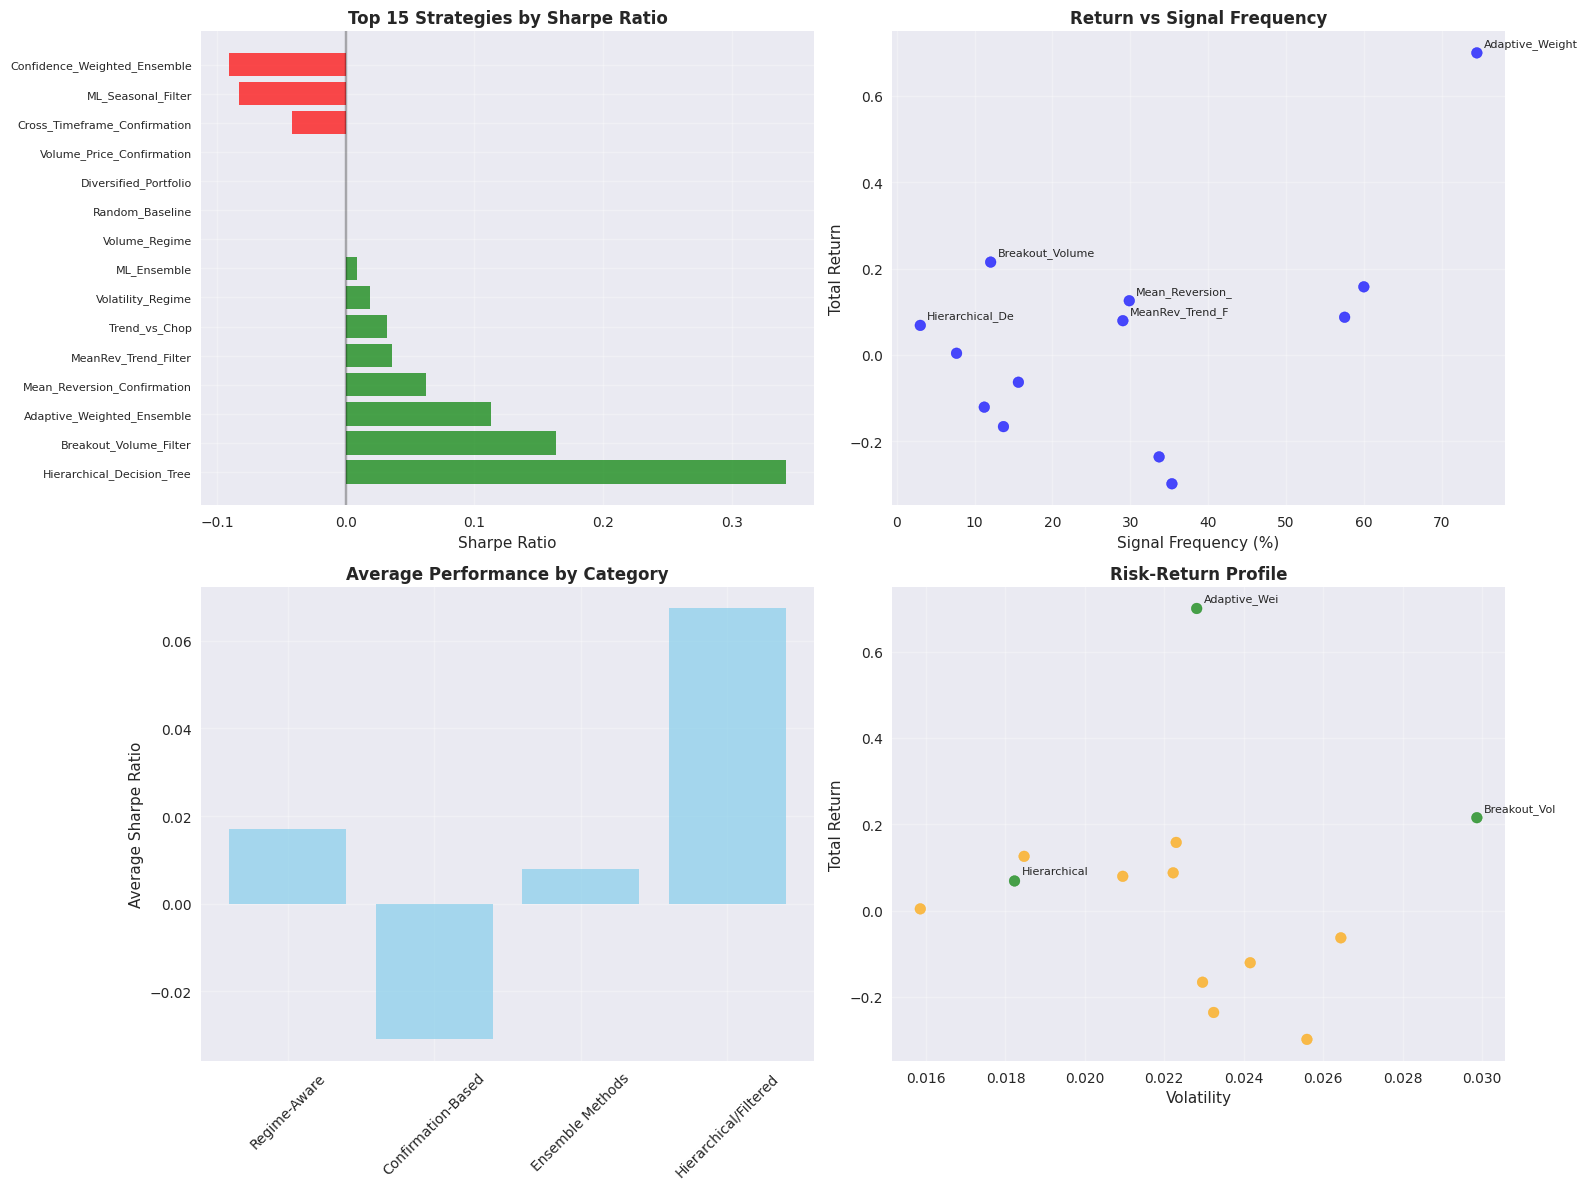

Comprehensive visualizations generated!

KEY INSIGHTS FROM RESULTS:
Best Overall Strategy: Hierarchical_Decision_Tree
   - Sharpe Ratio: 0.342
   - Total Return: 0.069
   - Signal Frequency: 3.01%
   - Total Signals: 11

Best Performing Category: Hierarchical/Filtered
   - Average Sharpe: 0.067

High-Frequency Strategies (>30% signals): 8
   - Average Sharpe: -0.001

Low-Frequency Strategies (<10% signals): 2
   - Average Sharpe: 0.176

COMPREHENSIVE SIGNAL COMBINATIONS ANALYSIS COMPLETE!
Ready for implementation and live testing!


In [11]:
# Create comprehensive visualization
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Sharpe Ratio Ranking
ax1 = axes[0, 0]
top_15 = performance_results.head(15)
colors = ['red' if name == 'Random_Baseline' else 'green' if sharpe > 0 else 'red' 
          for name, sharpe in zip(top_15['strategy_name'], top_15['sharpe_ratio'])]

bars1 = ax1.barh(range(len(top_15)), top_15['sharpe_ratio'], color=colors, alpha=0.7)
ax1.set_yticks(range(len(top_15)))
ax1.set_yticklabels(top_15['strategy_name'], fontsize=8)
ax1.set_xlabel('Sharpe Ratio')
ax1.set_title('Top 15 Strategies by Sharpe Ratio', fontweight='bold')
ax1.axvline(x=0, color='black', linestyle='-', alpha=0.3)
ax1.grid(True, alpha=0.3)

# Plot 2: Total Return vs Signal Frequency
ax2 = axes[0, 1]
scatter_colors = ['red' if name == 'Random_Baseline' else 'blue' 
                 for name in performance_results['strategy_name']]

scatter = ax2.scatter(performance_results['signal_frequency'] * 100, 
                     performance_results['total_return'],
                     c=scatter_colors, alpha=0.7, s=60)

ax2.set_xlabel('Signal Frequency (%)')
ax2.set_ylabel('Total Return')
ax2.set_title('Return vs Signal Frequency', fontweight='bold')
ax2.grid(True, alpha=0.3)

# Add labels for top performers
for _, row in performance_results.head(5).iterrows():
    ax2.annotate(row['strategy_name'][:15], 
                (row['signal_frequency'] * 100, row['total_return']),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

# Plot 3: Category Performance Comparison
ax3 = axes[1, 0]
category_performance = {}

for category, strategy_names in categories.items():
    category_results = performance_results[performance_results['strategy_name'].isin(strategy_names)]
    if not category_results.empty:
        category_performance[category] = category_results['sharpe_ratio'].mean()

if category_performance:
    categories_list = list(category_performance.keys())
    sharpe_values = list(category_performance.values())
    
    bars3 = ax3.bar(categories_list, sharpe_values, color='skyblue', alpha=0.7)
    ax3.set_ylabel('Average Sharpe Ratio')
    ax3.set_title('Average Performance by Category', fontweight='bold')
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(True, alpha=0.3)

# Plot 4: Risk-Return Profile
ax4 = axes[1, 1]
risk_return_colors = ['red' if name == 'Random_Baseline' else 'green' if sharpe > 0.1 else 'orange'
                     for name, sharpe in zip(performance_results['strategy_name'], 
                                           performance_results['sharpe_ratio'])]

ax4.scatter(performance_results['volatility'], 
           performance_results['total_return'],
           c=risk_return_colors, alpha=0.7, s=60)

ax4.set_xlabel('Volatility')
ax4.set_ylabel('Total Return')
ax4.set_title('Risk-Return Profile', fontweight='bold')
ax4.grid(True, alpha=0.3)

# Add labels for extreme points
for _, row in performance_results.head(3).iterrows():
    ax4.annotate(row['strategy_name'][:12], 
                (row['volatility'], row['total_return']),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()

print("Comprehensive visualizations generated!")
print("\nKEY INSIGHTS FROM RESULTS:")
print("=" * 50)

# Generate insights
if not performance_results.empty:
    best_strategy = performance_results.iloc[0]
    print(f"Best Overall Strategy: {best_strategy['strategy_name']}")
    print(f"   - Sharpe Ratio: {best_strategy['sharpe_ratio']:.3f}")
    print(f"   - Total Return: {best_strategy['total_return']:.3f}")
    print(f"   - Signal Frequency: {best_strategy['signal_frequency']:.2%}")
    print(f"   - Total Signals: {best_strategy['total_signals']:.0f}")
    
    # Category insights
    if category_performance:
        best_category = max(category_performance.keys(), key=lambda x: category_performance[x])
        print(f"\nBest Performing Category: {best_category}")
        print(f"   - Average Sharpe: {category_performance[best_category]:.3f}")
    
    # Signal frequency insights
    high_freq_strategies = performance_results[performance_results['signal_frequency'] > 0.3]
    low_freq_strategies = performance_results[performance_results['signal_frequency'] < 0.1]
    
    if not high_freq_strategies.empty:
        print(f"\nHigh-Frequency Strategies (>30% signals): {len(high_freq_strategies)}")
        print(f"   - Average Sharpe: {high_freq_strategies['sharpe_ratio'].mean():.3f}")
    
    if not low_freq_strategies.empty:
        print(f"\nLow-Frequency Strategies (<10% signals): {len(low_freq_strategies)}")
        print(f"   - Average Sharpe: {low_freq_strategies['sharpe_ratio'].mean():.3f}")

print("\n" + "=" * 50)
print("COMPREHENSIVE SIGNAL COMBINATIONS ANALYSIS COMPLETE!")
print("Ready for implementation and live testing!")


# End of notebook
